<a href="https://colab.research.google.com/github/Ana-AlonsoCanizares/AA_GRUPO3/blob/main/Lab04_Pr03_enfermeria.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Puestos de enfermería
###Objetivo de la práctica

Una empresa de colocación de trabajadores pretende hacer una aplicación para ser más eficiente en los enfermeros y enfermeras que asignan para cuidados en hogares. Para ello se dispone del archivo csv “enfermeria” con las características de las distintas personas que pueden optar a los puestos. Crear un modelo que agrupe los candidatos y establezca como se relacionan entre ellos jerárquicamente.

###Importación de librerías

In [12]:
# Importamos librerías
import numpy as np 
import pandas as pd 
import sklearn as sk
from sklearn import datasets
import matplotlib.pyplot as plt 
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder 
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.cluster.hierarchy import linkage, dendrogram
import scipy.cluster.hierarchy as sch
from sklearn.cluster import KMeans

In [2]:
# Lectura de la base de datos
filename = 'enfermeria.csv'
data = pd.read_csv(filename, sep = ',')

data.head(20)

,parents_occupation,childs_nursery,family_form,number_children,housing_conditions,financial_standing,social_conditions,health_conditions,recommendation
0,usual,proper,complete,1,convenient,convenient,nonprob,recommended,recommend
1,usual,proper,complete,1,convenient,convenient,nonprob,priority,priority
2,usual,proper,complete,1,convenient,convenient,nonprob,not_recom,not_recom
3,usual,proper,complete,1,convenient,convenient,slightly_prob,recommended,recommend
4,usual,proper,complete,1,convenient,convenient,slightly_prob,priority,priority
5,usual,proper,complete,1,convenient,convenient,slightly_prob,not_recom,not_recom
6,usual,proper,complete,1,convenient,convenient,problematic,recommended,priority
7,usual,proper,complete,1,convenient,convenient,problematic,priority,priority
8,usual,proper,complete,1,convenient,convenient,problematic,not_recom,not_recom
9,usual,proper,complete,1,convenient,inconv,nonprob,recommended,very_recom


### Revisión, limpieza y preprocesamiento de datos

In [3]:
# Revisión de los tipos de datos
print(data.shape)

(12960, 9)


In [4]:
# No hay nan
print(data.info())

# Quitamos los duplicados que tampoco hay
data = data.drop_duplicates()

print(data.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12960 entries, 0 to 12959
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   parents_occupation  12960 non-null  object
 1   childs_nursery      12960 non-null  object
 2   family_form         12960 non-null  object
 3   number_children     12960 non-null  object
 4   housing_conditions  12960 non-null  object
 5   financial_standing  12960 non-null  object
 6   social_conditions   12960 non-null  object
 7   health_conditions   12960 non-null  object
 8   recommendation      12960 non-null  object
dtypes: object(9)
memory usage: 911.4+ KB
None
(12960, 9)


A continuación, procedemos a pasar todas las variables categóricas a numéricas para poder calcular posteriormente las distancias con LabelEncoder.fit_transform que es una función de preprocesamiento de sklearn.

In [6]:
encoder = LabelEncoder()
for col in data.columns:
    if data[col].dtype == 'object':
        data[col] = encoder.fit_transform(data[col])

In [7]:
data

,parents_occupation,childs_nursery,family_form,number_children,housing_conditions,financial_standing,social_conditions,health_conditions,recommendation
0,2,3,0,0,0,0,0,2,2
1,2,3,0,0,0,0,0,1,1
2,2,3,0,0,0,0,0,0,0
3,2,3,0,0,0,0,2,2,2
4,2,3,0,0,0,0,2,1,1
...,...,...,...,...,...,...,...,...,...
12955,0,4,2,3,1,1,2,1,3
12956,0,4,2,3,1,1,2,0,0
12957,0,4,2,3,1,1,1,2,3
12958,0,4,2,3,1,1,1,1,3


### Apartado 1
Utiliza varias configuraciones para el modelo que más se adapte y teniendo en cuenta los tipos
de distancias entre elementos. ¿Cuál es la k del modelo?

Probaremos con 2, 3, 4 y 5 clusters, utilizando las distancias Euclídea y de Manhattan.
Calculadas de esta manera:

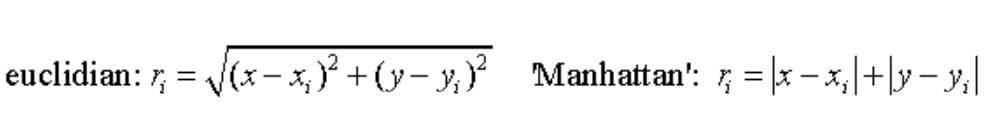


La distancia Euclídea es la única que utilizar el criterio de entrelazamiento ward, por lo que utilizaremos la distancia máxima (complete) para la distancia de Manhattan.

In [8]:
# Número de clusters y métricas a probar
n_clusters = [2, 3, 4, 5]
metricas = ['euclidean', 'manhattan']

# Inicializar lista para almacenar resultados
resultados = []

# Iterar sobre valores de parámetros
for n in n_clusters:
  for m in metricas:
    if m == 'euclidean':
      # Inicialización del modelo
      modelo = AgglomerativeClustering(n_clusters=n, metric=m, linkage='ward')
    else:
      modelo = AgglomerativeClustering(n_clusters=n, metric=m, compute_full_tree=True, linkage='complete')
    # Entrenamos modelo
    modelo.fit(data)
    # Predicción de los clusters
    pred = modelo.fit_predict(data)
    # Calculamos el score
    score = silhouette_score(data, pred)
    # Almacenar resultados en lista
    resultados.append((m, n, pred, score))

Procedemos a ver cúal de los 8 modelos nos devuelve el mejor resultado.

In [9]:
# Vemos los resultados
for resul in resultados:
  print("Métrica:", resul[0])
  print("Número de clusters:", resul[1])
  print("Predicciones:", resul[2])
  print("Score:", resul[3],"\n")

Métrica: euclidean
Número de clusters: 2
Predicciones: [1 1 1 ... 0 0 1]
Score: 0.189307953603608 

Métrica: manhattan
Número de clusters: 2
Predicciones: [0 0 0 ... 1 1 0]
Score: 0.189307953603608 

Métrica: euclidean
Número de clusters: 3
Predicciones: [0 0 0 ... 1 1 0]
Score: 0.17343580251679594 

Métrica: manhattan
Número de clusters: 3
Predicciones: [0 0 0 ... 1 1 2]
Score: 0.11275457972876789 

Métrica: euclidean
Número de clusters: 4
Predicciones: [0 0 0 ... 3 3 0]
Score: 0.15221165581957358 

Métrica: manhattan
Número de clusters: 4
Predicciones: [1 3 3 ... 0 0 2]
Score: 0.06891358776805691 

Métrica: euclidean
Número de clusters: 5
Predicciones: [1 1 1 ... 3 3 4]
Score: 0.14158072504896616 

Métrica: manhattan
Número de clusters: 5
Predicciones: [0 1 1 ... 4 4 2]
Score: 0.10310575151718784 



Observamos que el modelo más óptimo es 2 clusters, utilizando la distancia Euclídea o Manhattan, un mismo valor devuelto (0.189).

Vamos a realizar la gráfica para utilizar el método del codo para reafirmar el resultado o elegir otro valor para la k y crear finalmente nuestro modelo. Hacemos uso del método Kmeans de la librería Sklearn.

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

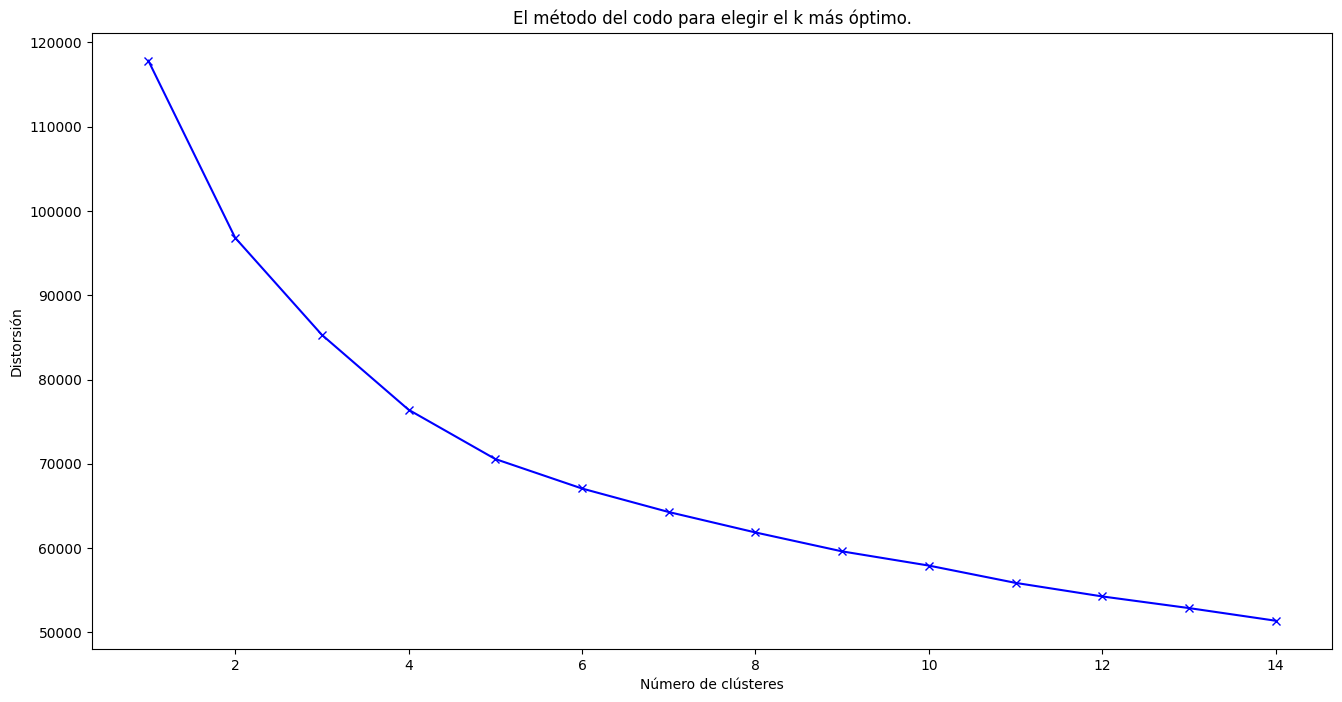

In [13]:
distortions = []
K = range(1,15)
for k in K:
    kmeanModel = KMeans(n_clusters=k, init = 'k-means++', random_state = 42)
    kmeanModel.fit(data)
    distortions.append(kmeanModel.inertia_)

# Gráfica del método del codo
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('Número de clústeres')
plt.ylabel('Distorsión')
plt.title('El método del codo para elegir el k más óptimo.')
plt.show()

Vemos que no hay un pico "codo" claro, por lo que vamos a tomar k = 3, de esta manera el análisis de los grupos será más sencillo de interpretar y poder sacar un mayor número de conclusiones.

Utilizaremos la distancia Euclidea, ya que para 3 clústeres el score es mucho mayor que utilizando la distancia de Manhattan. 

Hacemos uso del método 'kmeans' de la librería sklearn.

In [14]:
k = 3
m = 'euclidean'
# Creamos el modelo
modelo_optimo = AgglomerativeClustering(n_clusters=k, affinity=m, linkage='ward')
# Entrenamos el modelo
modelo_optimo.fit(data)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


AgglomerativeClustering(affinity='euclidean', n_clusters=3)

Observamos que de los clústeres creados, el que más individuos contiene es el 0, mientras que los otros dos están bastante igualados.

Creamos una nueva columna dentro del dataframe que contiene el cluster al que pertenece cada individuo.

In [15]:
# Columna nueva con cluster al que pertenece la fila
data['cluster'] = modelo_optimo.labels_

# Contamos cuantos hay de cada tipo 
data.value_counts(data['cluster'])

cluster
0    8588
1    2306
2    2066
dtype: int64

## Apartado 2

Dibuja un dendograma con los clusters obtenidos. Explica alguna de las relaciones interesantes que puedas encontrar.

Dibujamos el dendograma que contiene las últimas 30 agrupaciones creadas, se pueden diferenciar 3 colores, el verde, el naranja y el azul.

La primera rama que se bifurca del resto es la naranja, posteriormente la verde y es la azul la que une ambas, a diferentes alturas. 

Las alturas muestran la distancia entre dichos clústeres, cuanto mayor es la altura, mayor es la distancia entre estos.

###Dendograma

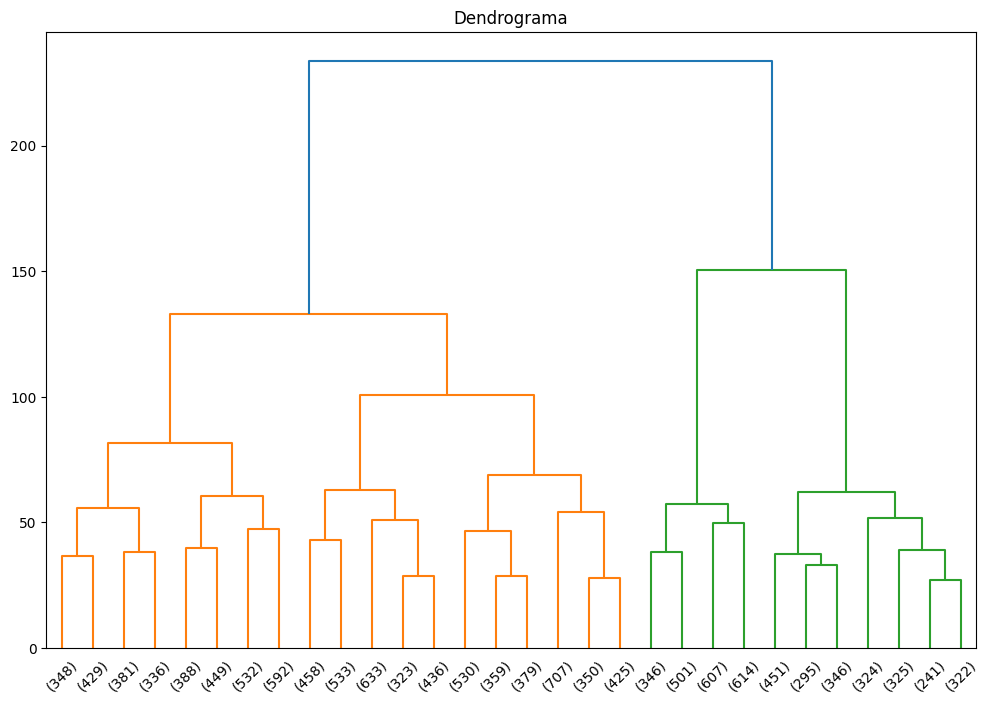

In [90]:
# Dendograma
plt.figure(figsize=(12, 8))
plt.title("Dendrograma") 
sch.dendrogram(sch.linkage(data, method = 'ward', metric='euclidean'), truncate_mode='lastp', p=30)
plt.show()

Los 30 números representados en el "eje X", muestran el número de individuos que pertenece a cada agrupación. Se puede observar que la distribución es más uniforme que cuando tomamos 3 clusters.

####Simplificación del dendograma

Ahora, vamos a representar solo los 3 clusters con los que hemos decidido trabajar, para ello pondremos el valor p = 3, el cual mostrará los últimos 3 clusters y el parámetro truncate_mode en 'lastp', truncando el dendograma por los clusters más pequeños.

Es por ello que nos mostrará los últimos 3 clústeres más pequeños, es decir, los que creamos con el modelo anteriormente.

De esta manera, será más fácil poder interpretar el dendograma.

Realizar este truncamiento resulta muy eficaz a la hora de tener una base de datos muy grande (como la nuestra), ya que simplificamos mucho el dendograma.

Como era de esperar, los que contienen menos individuos son más parecidos que el cluster 0.

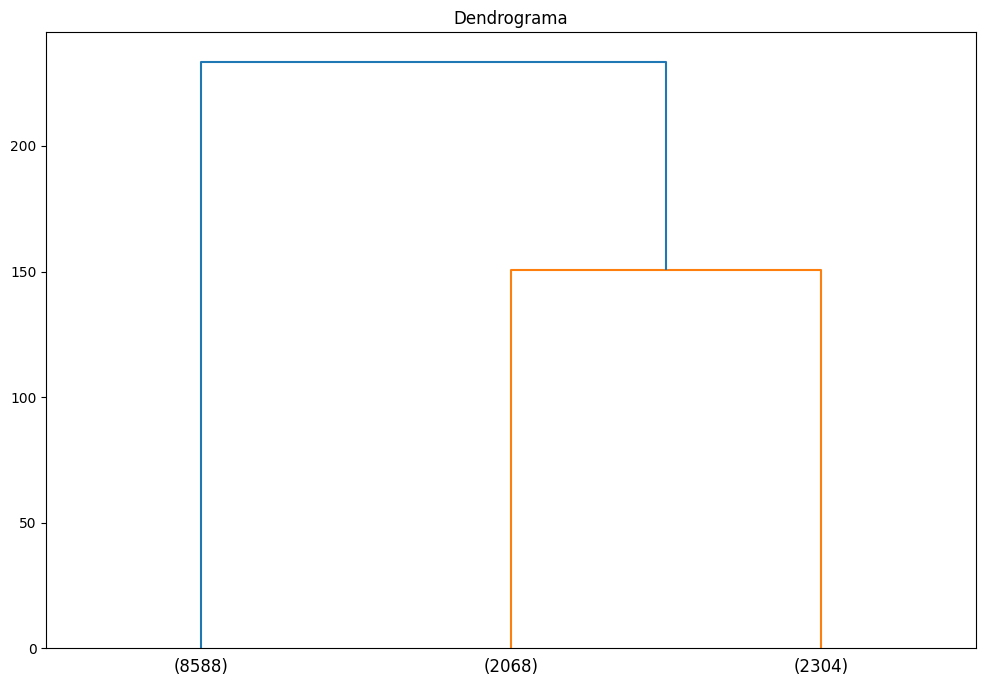

In [17]:
# Los clusters elegidos, k = 3
plt.figure(figsize=(12, 8))  
plt.title("Dendrograma") 
sch.dendrogram(sch.linkage(data, method = 'ward', metric='euclidean'), truncate_mode='lastp', p=3)
plt.show()

### Análisis de resultados

Para poder sacar conclusiones, hay que hacer un estudio de los resultados obtenidos.

Primero realizamos un análisis de correlación; calculando la correlación entre las características de los individuos en un mismo cluster para poder identificar posibles relaciones.

In [18]:
# Separamos los datos según el cluster al que pertenecen

data0 = data[data['cluster'] == 0]
data1 = data[data['cluster'] == 1]
data2 = data[data['cluster'] == 2]

datos = [data0, data1, data2]

Podemos observar que no hay correlaciones fuertes, son todas muy pequeñas. Solo destacan las relaciones que hay en algunas de las variables del segundo cluster, las más relacionadas son:

childs_nursery y recommendation con 0.596749 de relación

recommendation y health_conditionscon 0.424454 de relación

In [19]:
import seaborn as sns

# Calculamos la matriz de correlación
for d in datos:
  matriz_correlacion = d.corr()

  # Identificamos las correlaciones más fuertes
  correlaciones_fuertes = matriz_correlacion.abs().unstack().sort_values(ascending=False).drop_duplicates()
  print(f"Las correlaciones de los datos del cluster son:")
  print(correlaciones_fuertes)
  print("\n\n")

Las correlaciones de los datos del cluster son:
parents_occupation  parents_occupation    1.000000e+00
health_conditions   recommendation        9.129600e-01
recommendation      parents_occupation    1.562622e-01
parents_occupation  health_conditions     9.241837e-02
childs_nursery      parents_occupation    8.672636e-02
number_children     parents_occupation    4.269554e-02
recommendation      number_children       4.124351e-02
parents_occupation  housing_conditions    3.291197e-02
housing_conditions  recommendation        3.220373e-02
financial_standing  housing_conditions    3.068374e-02
                    parents_occupation    2.726585e-02
                    recommendation        2.667912e-02
health_conditions   number_children       2.606937e-02
family_form         recommendation        2.435664e-02
parents_occupation  family_form           2.380289e-02
family_form         number_children       2.063323e-02
health_conditions   housing_conditions    2.029116e-02
                 

####Matrices de correlación

En esta primera matriz de correlación de los datos del cluster cero, podemos ver que la mayoría de las variables no se encuentran relacionadas, solo la de 'health_conditions' y 'recommendation'.

<Axes: >

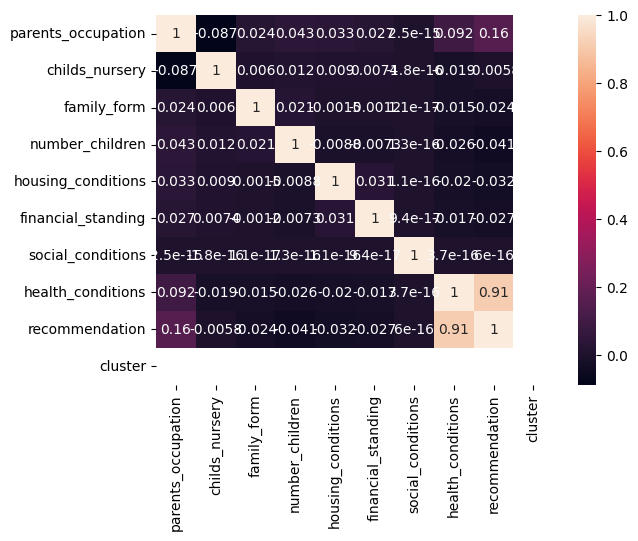

In [20]:
# Visualizar la matriz de correlación de data0
m_c0 = data0.corr()
sns.heatmap(m_c0, annot=True)

En la del cluster uno, podemos ver que la mayoría de las variables no se tampoco están relacionadas, además las variables 'health_conditions' y 'recommendation', se encuentran relacionadas pero mucho menos que en el cluster anterior.

<Axes: >

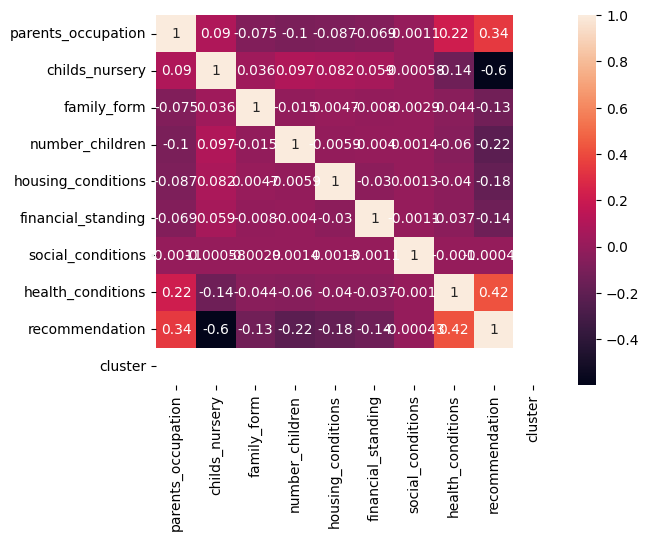

In [21]:
# Visualizar la matriz de correlación de data1
m_c1 = data1.corr()
sns.heatmap(m_c1, annot=True)

Muy similar a las dos matrices previas, no encontramos relación entre las variables del dataset que contiene los individuos del cluster 3.

<Axes: >

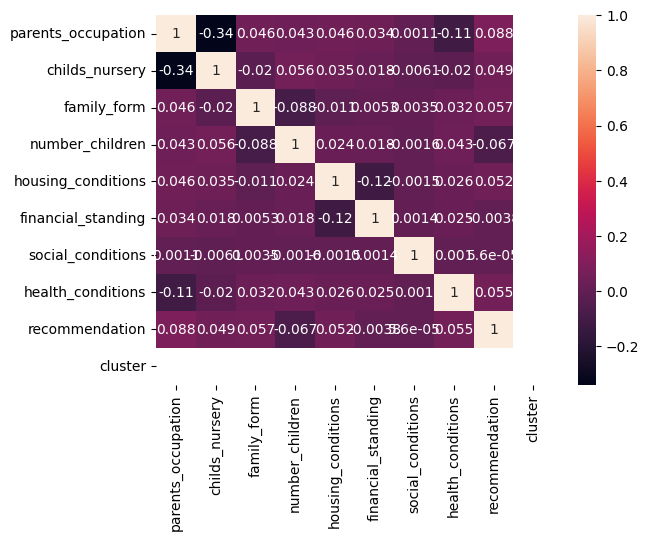

In [22]:
# Visualizar la matriz de correlación de data2
m_c2 = data2.corr()
sns.heatmap(m_c2, annot=True)

No encontramos correlaciones destacables entre las diferentes variables de un mismo cluster, por lo que procederemos a hacer un estudio con las medias de cada atributo para ver cómo se comportan para cada cluster.

###Cálculo de medias y desviaciones típicas

Calculamos las medias y las desviaciones típicas de todas las columnas de cada uno de los 3 datasets de cada cluster por separado.

Así, podremos ver si hay alguna tendencia en los datos. Es decir, saber si alguna de las variables se repite en muchos de los individuos de un mismo cluster. 

In [23]:
# Cálculo de media y desviacion de los diferentes parámetros para los 3 clústeres
mean_std = []

for d in datos:
  for columna in d:
    media = d[columna].mean()
    desviacion = d[columna].std() 
    mean_std.append((d, columna, media, desviacion))

for m in mean_std:
  print("Del dataframe que contiene los individuos del cluster", m[0]['cluster'].iloc[[0]])
  print("De la columna", m[1], "la media es ", round(m[2], 4), "y la desviación típica es ", round(m[3], 4),".\n")

Del dataframe que contiene los individuos del cluster 0    0
Name: cluster, dtype: int64
De la columna parents_occupation la media es  1.1244 y la desviación típica es  0.8026 .

Del dataframe que contiene los individuos del cluster 0    0
Name: cluster, dtype: int64
De la columna childs_nursery la media es  1.9923 y la desviación típica es  1.2578 .

Del dataframe que contiene los individuos del cluster 0    0
Name: cluster, dtype: int64
De la columna family_form la media es  1.4735 y la desviación típica es  1.1238 .

Del dataframe que contiene los individuos del cluster 0    0
Name: cluster, dtype: int64
De la columna number_children la media es  1.4546 y la desviación típica es  1.1232 .

Del dataframe que contiene los individuos del cluster 0    0
Name: cluster, dtype: int64
De la columna housing_conditions la media es  0.9739 y la desviación típica es  0.8282 .

Del dataframe que contiene los individuos del cluster 0    0
Name: cluster, dtype: int64
De la columna financial_standi

Cargamos los datos de nuevo para poder interpretar los índices, es decir, hacer la conversión de numérica a la categoría asociada y poder sacar conclusiones.

In [ ]:
datos = pd.read_csv(filename, sep = ',')

Con los datos sacados, vamos a fijarnos en aquellos cuya desviación típica sea baja y sacaremos conclusiones que respaldaremos con un conteo de dichas variables, comprobando que es verdad que hay una relación entre estas y el cluster al que pertenecen los individuos que la contengan.

La única media y desviación típica lo suficientemente clara se puede ver en el cluster dos para la columna 'recommendation'.

Se reconoce una media de 3.0019 con una desviación típica de 0.044 (muy pequeña) para la columna 'recommendation', lo que muestra que casi todos los individuos de este cluster tienden a tomar 3 como valor en esta variable.

A continuación, mostramos el conteo de dicha variable y miraremos a qué corresponde dicho valor.

In [24]:
data2.value_counts(data2['recommendation'])

recommendation
3    2062
4       4
dtype: int64

Observamos como la mayoría de individuos toma el valor 3, como nos mostraba la media y la desviación típica.

Buscamos los individuos que tienen en recomendación un 3 o un 4 para ver que significan estos parámetros en el dataset original.

Obtenemos que los individuos del cluster 2 tienen como valor de recomendación prioridad especial.

In [26]:
# Localizamos los individuos con recommendation == 3 o == 4
i_3 = np.where(data['recommendation'] == 3 )[0][0]
i_4 = np.where(data['recommendation'] == 4 )[0][0]

# Miramos que significa este valor en el df original
print(datos['recommendation'][i_3]) # Special priority
print(datos['recommendation'][i_4]) # Very recommencation

spec_prior
very_recom


Ahora realizaremos un conteo del resto de variables para entender que tienen en común los individuos de un mismo cluster.

Para los individuos del cluster 0, en financial standing toma los dos valores posibles para este parámetro a partes iguales (más o menos), por lo que esta variable no es relevante para el cluster.

Esto pasa con más de un parámetro, por lo que no describiremos todos ellos, pues no son relevantes para el cluster.

In [28]:
datos.value_counts(datos['financial_standing'])

financial_standing
convenient    6480
inconv        6480
dtype: int64

In [27]:
data0.value_counts(data0['financial_standing'])

financial_standing
0    4406
1    4182
dtype: int64

En el cluster 0, observamos que los valores tienden a dos de cinco posibles valores, que corresponden con 'No recomendado' y 'prioridad'.

In [86]:
data0.value_counts(data0['recommendation'])

recommendation
0    4320
1    4266
2       2
dtype: int64

In [42]:
# Localizamos los individuos con recommendation == 0 o == 1
i_0 = np.where(data['recommendation'] == 0 )[0][0]
i_1 = np.where(data['recommendation'] == 1 )[0][0]
i_2 = np.where(data['recommendation'] == 2 )[0][0]

# Miramos que significa este valor en el df original
print(datos['recommendation'][i_0]) # Not recommended
print(datos['recommendation'][i_1]) # Priority
print(datos['recommendation'][i_2]) # Recommended

not_recom
priority
recommend


Por último, la columna de 'health_conditions' contiene todos los valores posibles, sin embargo, el porcentaje más alto de dichos individuos tienen como health condition no recomendada, luego prioridad, y los que menos, recomendado.

In [89]:
data0.value_counts(data0['health_conditions'])

health_conditions
0    4320
2    2414
1    1854
dtype: int64

In [ ]:
# Localizamos los individuos con recommendation == 0 o == 1
i_0 = np.where(data['health_conditions'] == 0 )[0][0]
i_1 = np.where(data['health_conditions'] == 1 )[0][0]
i_2 = np.where(data['health_conditions'] == 2 )[0][0]

# Miramos que significa este valor en el df original
print(datos['health_conditions'][i_0]) # Not recommended
print(datos['health_conditions'][i_1]) # Priority
print(datos['health_conditions'][i_2]) # Recommended

Ninguno de los individuos pertenecientes al cluster 1, tienen como valor de health_condition no recomendado, son de prioridad o recomendado.

In [73]:
data1.value_counts(data1['health_conditions'])

health_conditions
1    1209
2    1097
dtype: int64

In [91]:
# Localizamos los individuos con recommendation == 1 o == 2
i_1 = np.where(data['health_conditions'] == 1 )[0][0]
i_2 = np.where(data['health_conditions'] == 2 )[0][0]

# Miramos que significa este valor en el df original
print(datos['health_conditions'][i_1]) # Priority
print(datos['health_conditions'][i_2]) # Recommended

priority
recommended


Y en la columna de recomendación solo toma dos valores que se refieren a prioridad especial y muy recomendado, de los cinco posibles.

In [77]:
data1.value_counts(data1['recommendation'])

recommendation
3    1982
4     324
dtype: int64

In [75]:
# Localizamos los individuos con recommendation == 0 o == 1
i_3 = np.where(data['recommendation'] == 3 )[0][0]
i_4 = np.where(data['recommendation'] == 4 )[0][0]

# Miramos que significa este valor en el df original
print(datos['recommendation'][i_3]) # Special priority
print(datos['recommendation'][i_4]) # Very recommended

spec_prior
very_recom


En el cluster 2, la variable children nursery toma 3 valores de 5 posibles, y sobre todo dos, que son crítico e impropio.

In [50]:
data2.value_counts(data2['childs_nursery'])

childs_nursery
0    1264
1     760
2      42
dtype: int64

In [51]:
# Localizamos los individuos con recommendation == 0, == 1 ó == 2
i_0 = np.where(data['childs_nursery'] == 0 )[0][0]
i_1 = np.where(data['childs_nursery'] == 1 )[0][0]
i_2 = np.where(data['childs_nursery'] == 2 )[0][0]

# Miramos que significa este valor en el df original
print(datos['childs_nursery'][i_0]) # Critical
print(datos['childs_nursery'][i_1]) # Improper
print(datos['childs_nursery'][i_2]) # Less proper

critical
improper
less_proper


### Conclusiones

Podemos sacar como conclusiones que los individuos pertenecientes al cluster 0 son aquellos cuya recomendación es no recomendado o prioridad y como health condition no recomendado (sobretodo).

El cluster 1 se encuentran los individuos con prioridad y recomendados en health condition y cuya recomendación es prioridad especial y muy recomendados.

Y por último, el cluster 2 que están contenidos los individuos cuya recomendación es de prioridad especial y en la variable childs_nursery toman  los valores crítico e impropio.